In [1]:
#!pip install pandas 
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

input_folder = "/content/drive/My Drive/segmentation/seleipiri"
output_folder = "/content/drive/My Drive/segmentation/seleipiri/output"
csv_output = "intensities_bgc.csv"
csv_output_path = os.path.join(output_folder,csv_output)

dapi = "D28_So10C3_03_DAPI.tiff"
dapi_path = os.path.join(input_folder,dapi)
ch_paths = [os.path.join(input_folder,"D28_So10C3_03_SOX2.tiff"),
            os.path.join(input_folder,"D28_So10C3_03_KI67.tiff"),
            os.path.join(input_folder,"D28_So10C3_03_TBR1.tiff")]

num_sizes = 10
min_rad_nucleus = 5 # approximate radius of the smallest cell in pixels
max_rad_nucleus = 25 # approximate radius of the largest cell in pixels
dapi_threshold = 500 # filter out dim nuclei (for 16-bit image max is 65536, so 500 should be low enough)
shape_channel_num = 1 # put 0 to use dapi for morphology metrics calculations

dpi = 600 # output image quality
# Potential error: 'NoneType' object has no attribute 'shape'. It means the file was not found
#Remember to change the name of the output path

Mounted at /content/drive


In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.measure import regionprops
from skimage.filters import gaussian, threshold_local, threshold_minimum
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.morphology import label,area_closing
from scipy import ndimage
from matplotlib import colors
import sys 
import random
import math


class Channel(object):
  def __init__(self,image,name):
    self.image = image
    self.name = name
    self.plot = None
    self.intensities = None

class Image(object):
  def __init__(self,dapi_path,bits,channels_paths): 
    self.dapi_path = dapi_path
    self.channels_paths = channels_paths
    self.bits = bits
    self.dpi = 600
    self.output_folder = "."
    self.channels = []
    self.cytoprops = []
    self.cell_count = 0
    self.dapi = None
    self.df = pd.DataFrame()

  def read(self):
    if not os.path.exists(self.dapi_path): 
      sys.exit(self.dapi_path+" file not found, check the file path for errors")
    self.dapi = cv2.imread(self.dapi_path,-1)
    self.h, self.w = self.dapi.shape
    self.channels = [Channel(self.dapi,"dapi")]
    cv2.normalize(self.dapi,self.dapi,0,2**self.bits,cv2.NORM_MINMAX)
    for ch_path in self.channels_paths:
      if not os.path.exists(ch_path): 
        sys.exit(ch_path+" file not found, check the file path for errors")
      self.channels.append(Channel(cv2.imread(ch_path,-1),os.path.splitext(os.path.basename(ch_path))[0]))

  def getcellprops(self,output_folder,dpi):
      self.dpi = dpi
      self.output_folder = output_folder
      output_area = np.zeros((self.h,self.w))
      output_perimeter = np.zeros((self.h,self.w))
      output_eccentricity = np.zeros((self.h,self.w))
      cells, self.X, self.Y, area, perimeter, eccentricity = [],[],[],[],[],[]
      for i in range(self.cell_count):
          if self.cytoprops[i]['area'] > 5:
              cells.append(self.cytoprops[i])
              self.X.append(self.cytoprops[i]['centroid'][0])
              self.Y.append(self.cytoprops[i]['centroid'][1])
              area.append(self.cytoprops[i]["area"])
              perimeter.append(self.cytoprops[i]["perimeter"])
              eccentricity.append(self.cytoprops[i]["eccentricity"])
              for coord in self.cytoprops[i]['coords']:
                output_area[coord[0],coord[1]] = self.cytoprops[i]["area"]
                output_perimeter[coord[0],coord[1]] = self.cytoprops[i]["perimeter"]
                output_eccentricity[coord[0],coord[1]] = self.cytoprops[i]["eccentricity"]
      self.cell_count = len(cells)
      self.cytoprops = cells
      self.plot(output_area,os.path.join(self.output_folder,"area.png"))
      self.plot(output_perimeter,os.path.join(self.output_folder,"perimeter.png"))
      self.plot(output_eccentricity,os.path.join(self.output_folder,"eccentricity.png"))
      self.df = pd.DataFrame({"X":self.X,"Y":self.Y,"area":area,"perimeter":perimeter,"eccentricity":eccentricity})

  def overlay_cells(self):
      for channel in self.channels:
        channel.plot = np.zeros((self.h,self.w))
        channel.intensities = np.zeros(self.cell_count)
        for i in range(self.cell_count):
            for coord in self.cytoprops[i]["coords"]:
                channel.intensities[i] += channel.image[coord[0],coord[1]]
            channel.intensities[i] = channel.intensities[i]/self.cytoprops[i]["area"]
            for coord in self.cytoprops[i]["coords"]:
                channel.plot[coord[0],coord[1]] = channel.intensities[i]
        self.plot(channel.plot,os.path.join(self.output_folder,channel.name+".png"))
        self.df[channel.name] = channel.intensities

  def plot(self,image,name,max=0):
      if max == 0:
        m = np.max(image)
      else:
        m = max
      cmap = colors.ListedColormap(['white','darkblue','blue','cornflowerblue',
                                    'cyan','aquamarine','lime','greenyellow','yellow','gold','orange','red','brown'])
      bounds=[0,1e-9,m/12,m/6,m/4,m/3,m/2.4,m/2,0.58*m,m/1.5,0.75*m,m/1.2,0.91*m,m]
      norm = colors.BoundaryNorm(bounds, cmap.N)
      image = plt.imshow(image, cmap=cmap, norm=norm)
      plt.colorbar(image, cmap='jet')
      plt.savefig(name,dpi=self.dpi,bbox_inches = "tight")
      plt.close()

  def filter(self,dapi_threshold=0):
    self.df.drop(labels = np.where(self.channels[0].intensities <= dapi_threshold)[0],inplace=True)
    for channel in self.channels:
      channel.intensities = channel.intensities[np.where(self.channels[0].intensities > dapi_threshold)]
      m = np.mean(channel.intensities)
      s = np.std(channel.intensities)
      channel.intensities[np.where(channel.intensities>m+2*s)] = m+2*s
    self.cell_count = len(channel.intensities)

  def display_threshold(self,channel,t):
    mask = np.copy(channel.plot)
    mask[np.where(channel.plot<t)] = 0
    image = np.copy(channel.image)
    image[np.where(mask!=0)] = np.max(channel.image)
    fig=plt.figure(figsize=(15,15)) 
    plt.subplot(1,2,1)
    plt.imshow(channel.image)
    plt.subplot(1,2,2)
    plt.imshow(image)
    plt.show()

  def adaptive_mask(self,img,high,num_sizes):
    confocal_blur = cv2.GaussianBlur(img, (3,3), 0)
    confocal_blur = 255*confocal_blur.astype(np.float64)/np.max(confocal_blur.astype(np.float64))
    total_mask = np.zeros((self.h,self.w))
    # Adaptive threshold at multiple window sizes
    # Minimum window size is diameter of largest cell
    # And maximum window size is the minimum shape of the confocal image
    # Choosing 20 equally spaced kernel sizes between these two
    for sz in np.linspace(high*2, np.min((self.h,self.w)),num_sizes):
        # Rounding floats and making sure they are odd
        sz = int(round(sz))
        if sz % 2 == 0: sz += 1
        confocal_mask = cv2.adaptiveThreshold(confocal_blur.astype('uint8'), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, sz, 0)
        # Bitwise or to combine this mask with the total mask
        total_mask = np.bitwise_or(total_mask.astype(np.uint8), confocal_mask.astype(np.uint8))
    return total_mask

  def segment_pearson(self,min_rad,max_rad,num_sizes,channel=0):
    low = min_rad # Minimum radius of nucleus
    high = max_rad # Maximum radius of nucleus
    step = 1
    # Finding the median and standard deviation of intensities of the confocal image
    med = np.median(self.dapi)
    std = np.std(self.dapi)
    # Thresholding outliers out
    # High-intensity outliers distort results so I truncate them
    thr = int(round(med+.95*std))
    lowthr = int(round(med-.95*std))
    if lowthr < 0: lowthr=0
    confocal_2 = cv2.threshold(self.dapi, thr, 255, cv2.THRESH_TRUNC)[1] # only used for entire colony mask
    # Generating approximate mask of entire colony
    # Useful for later, deciding which seeds are cells and which are noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (high*4+1,high*4+1))
    closed = cv2.morphologyEx(confocal_2, cv2.MORPH_CLOSE, kernel, iterations=1)
    closed = 255*closed.astype(np.float64)/np.max(closed)
    m = cv2.threshold(closed.astype(np.uint8), 0, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY)[1]
    # Gaussian blurring in preparation for adaptive thresh
    total_mask = self.adaptive_mask(self.dapi,high,num_sizes)
    # As in paper- standard deviation sigma of gaussian = radius/sqrt(2)
    # Finding range of sigmas using range of radii
    sigma = np.arange(low, high+step, step)/math.sqrt(2)
    agg = np.zeros((confocal_2.shape[0], confocal_2.shape[1], len(sigma)))
    # Gaussian of Laplacian
    for i, s in enumerate(sigma):
        im = gaussian(self.dapi, s)
        im = cv2.Laplacian(im, cv2.CV_64F, ksize=1)
        # Normalizing by dividing by squared sigma
        n_im_norm = im/(s**2)
        # Inverting so blob centers are local maxima rather than minima
        n_im_inv = np.max(n_im_norm)-n_im_norm
        # Adding to array storing all LoG results
        agg[:,:,i] = n_im_inv
    # Finding maximum value of each pixel across all LoG results at different sigma values
    max_agg = np.amax(agg, axis=2)
    # Finding local minima. Minimum distance between maxima is minimum radius of nucleus
    loc_inds = peak_local_max(max_agg, min_distance=low)
    locs = np.zeros(max_agg.shape)
    locs[loc_inds[:,0], loc_inds[:,1]]=1
    # From before: m is an approximate mask of colony. This removes false seeds generated by noise
    locs[m==0] = 0
    # Label and randomize label of seeds
    labels = label(locs)
    # Watershed
    if channel == 0:
      nuclei_labels = watershed(total_mask, labels, mask = total_mask)
    else:
      nuclei_labels = watershed(cv2.GaussianBlur(-self.channels[channel-1].image, (3,3), 0), labels, mask = self.adaptive_mask(self.channels[channel-1].image,1.5*high,num_sizes),watershed_line=True)
    self.mask = total_mask&m
    self.cytoprops = regionprops(nuclei_labels)
    self.cell_count = len(self.cytoprops)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


overlaid mask and image: blue is leftover dapi staining (false negative?),
green is false positive cells, light blue is correct segmentation


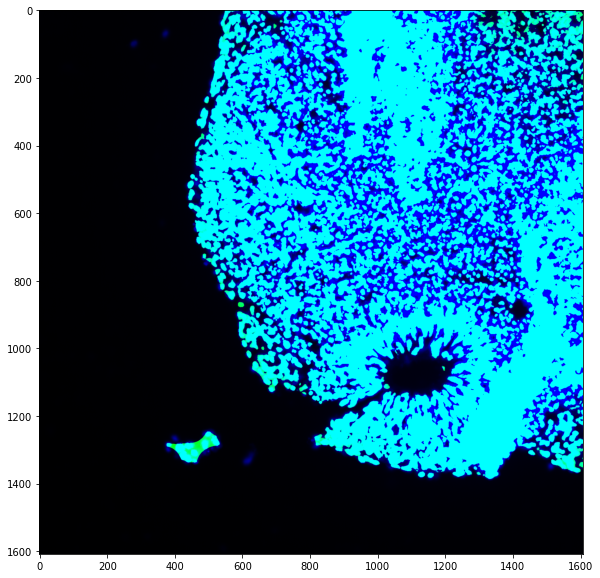

csv file with cell intensities is saved to /content/drive/My Drive/segmentation/seleipiri/output/intensities_bgc.csv


In [60]:
image = Image(dapi_path,16,ch_paths)
image.read()
image.segment_pearson(min_rad_nucleus,max_rad_nucleus,num_sizes,channel=shape_channel_num) 
image.getcellprops(output_folder,dpi) 
image.overlay_cells()
print("overlaid mask and image: blue is leftover dapi staining (false negative?),")
print("green is false positive cells, light blue is correct segmentation")
mask = np.zeros((image.h,image.w,3))
mask[:,:,1] = np.array(image.mask,dtype="uint16")
mask[:,:,2] = image.dapi/np.mean(image.dapi)
fig=plt.figure(figsize=(10,10)) 
plt.imshow(mask)
plt.show()
image.df.to_csv(csv_output_path)
save_df = image.df
print("csv file with cell intensities is saved to",csv_output_path)

K-means clustering

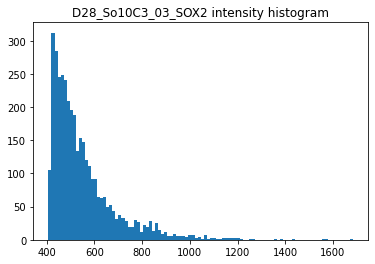

K-means threshold is 646.9324817518249


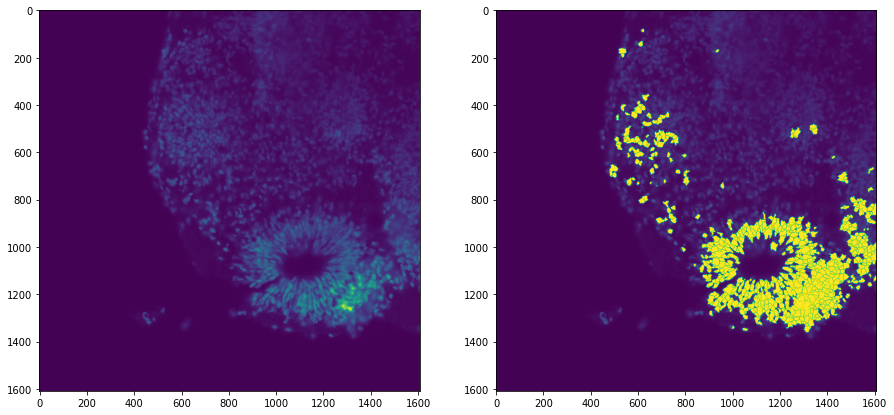

D28_So10C3_03_SOX2 positive count: 646 out of 3700 cells, that's 17.45945945945946 %


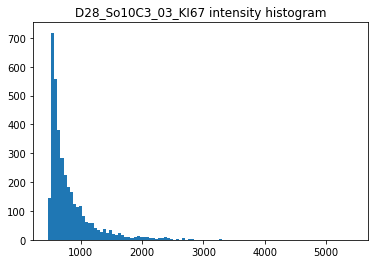

K-means threshold is 1248.3806228373703


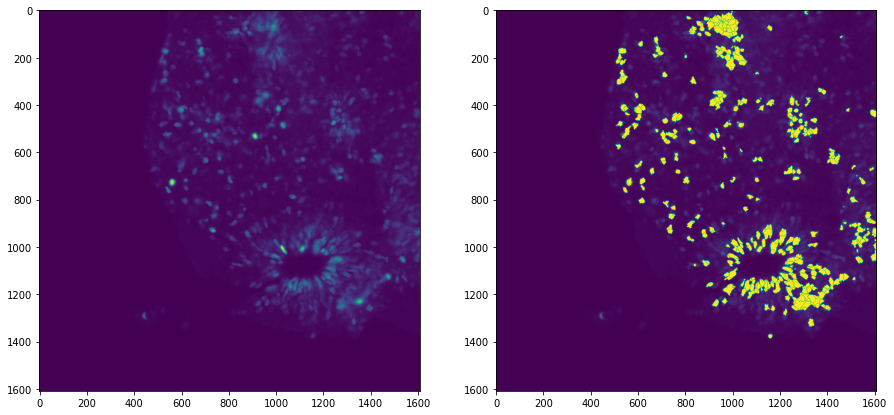

D28_So10C3_03_KI67 positive count: 405 out of 3700 cells, that's 10.945945945945946 %


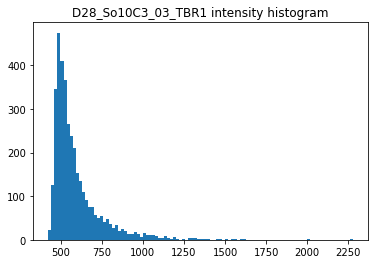

K-means threshold is 718.0814814814814


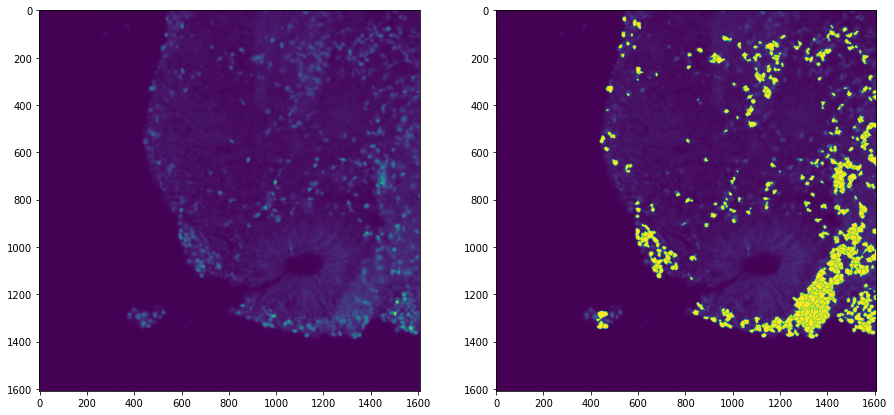

D28_So10C3_03_TBR1 positive count: 550 out of 3700 cells, that's 14.864864864864865 %
Colocalization of D28_So10C3_03_SOX2 D28_So10C3_03_KI67 is 199 out of 646 D28_So10C3_03_SOX2 positive cells, that's 30.804953560371516 %


In [63]:
from sklearn.cluster import KMeans

#image.filter(dapi_threshold = 500)
image.df = save_df
for channel in image.channels:
  if channel.name == "dapi":continue
  plt.hist(channel.intensities,bins=100)
  plt.title(channel.name+" intensity histogram")
  plt.show()
  kmeans = KMeans(n_clusters=2, random_state=0).fit(channel.intensities.reshape(-1, 1))
  class0mean = np.mean(channel.intensities[np.where(kmeans.labels_== 0)])
  class1mean = np.mean(channel.intensities[np.where(kmeans.labels_== 1)])
  if class0mean > class1mean:
    labels = np.array(np.logical_not(kmeans.labels_),dtype="int")
  else:
    labels = kmeans.labels_
  t = np.max(channel.intensities[np.where(labels == 0)])
  print("K-means threshold is",t)
  image.display_threshold(channel,t)
  image.df[channel.name+" positive"] = labels
  positive_count = np.sum(labels)

  print(channel.name,"positive count:",positive_count,"out of",image.cell_count,"cells, that's",100*positive_count/image.cell_count,"%")

image.df.to_csv(csv_output_path)

coloc = np.logical_and(image.df[image.channels[1].name+" positive"],image.df[image.channels[2].name+" positive"])

print("Colocalization of",image.channels[1].name,image.channels[2].name,"is",np.sum(coloc),
      "out of",np.sum(image.df[image.channels[1].name+" positive"]),image.channels[1].name,
      "positive cells, that's",100*np.sum(coloc)/np.sum(image.df[image.channels[1].name+" positive"]),"%")

Try another thresholding method:
Change the threshold method in the 6th line to one listed in the first line: threshold_otsu, threshold_triangle, threshold_mean, threshold_isodata, threshold_li.
I noticed that threshold_mean looks good, so that's what I put there by default

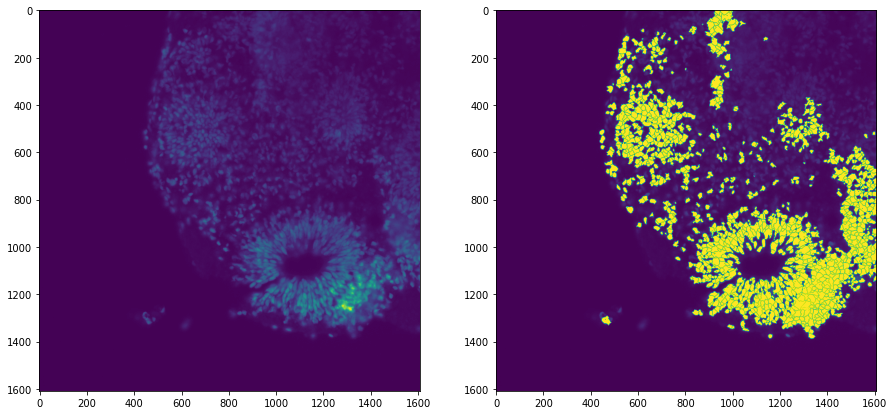

threshold is 551.9011852234463
D28_So10C3_03_SOX2 positive count: 1332 out of 3700 cells, that's 36.0 %


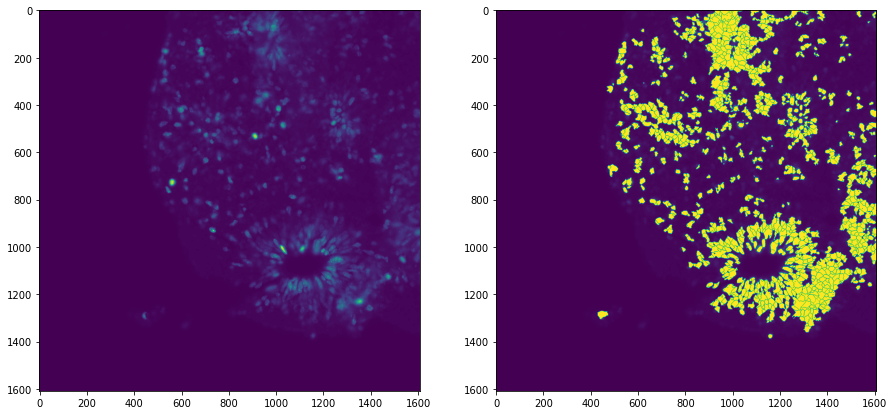

threshold is 825.1840248145301
D28_So10C3_03_KI67 positive count: 1158 out of 3700 cells, that's 31.2972972972973 %


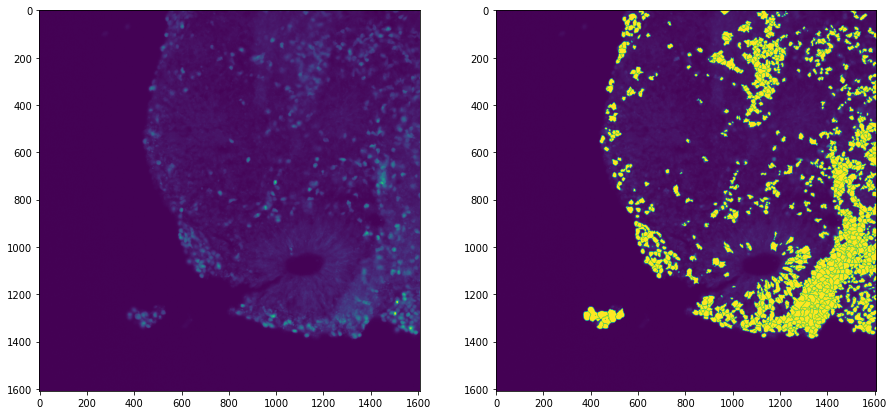

threshold is 594.4947110285771
D28_So10C3_03_TBR1 positive count: 1197 out of 3700 cells, that's 32.351351351351354 %
Colocalization of D28_So10C3_03_SOX2 D28_So10C3_03_KI67 is 780 out of 1332 D28_So10C3_03_SOX2 positive cells, that's 58.55855855855856 %


In [61]:
from skimage.filters import threshold_otsu, threshold_triangle, threshold_mean, threshold_isodata, threshold_li
image.df = save_df
thresholds = []
for channel in image.channels:
  if channel.name == "dapi":continue
  t = threshold_mean(channel.intensities.reshape(-1, 50))
  thresholds.append(t)
  image.display_threshold(channel,t)
  print("threshold is",t)

  labels = channel.intensities>t
  image.df[channel.name+" positive"] = labels
  positive_count = np.sum(labels)
  print(channel.name,"positive count:",positive_count,"out of",image.cell_count,"cells, that's",100*positive_count/image.cell_count,"%")

image.df.to_csv(csv_output_path)

coloc = np.logical_and(image.df[image.channels[1].name+" positive"],image.df[image.channels[2].name+" positive"])

print("Colocalization of",image.channels[1].name,image.channels[2].name,"is",np.sum(coloc),
      "out of",np.sum(image.df[image.channels[1].name+" positive"]),image.channels[1].name,
      "positive cells, that's",100*np.sum(coloc)/np.sum(image.df[image.channels[1].name+" positive"]),"%")

Use your own thresholds: make a list of threshold numbers as long as your number of channels (excluding dapi)

[551.9011852234463, 825.1840248145301, 594.4947110285771]


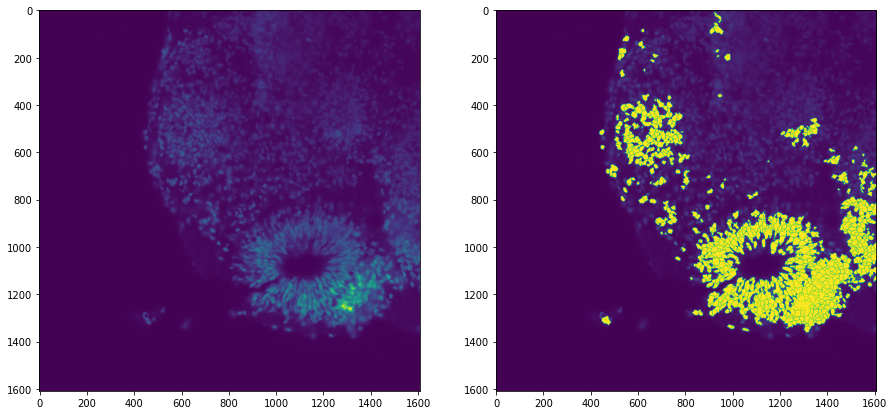

threshold is 600
D28_So10C3_03_SOX2 positive count: 906 out of 3700 cells, that's 24.486486486486488 %


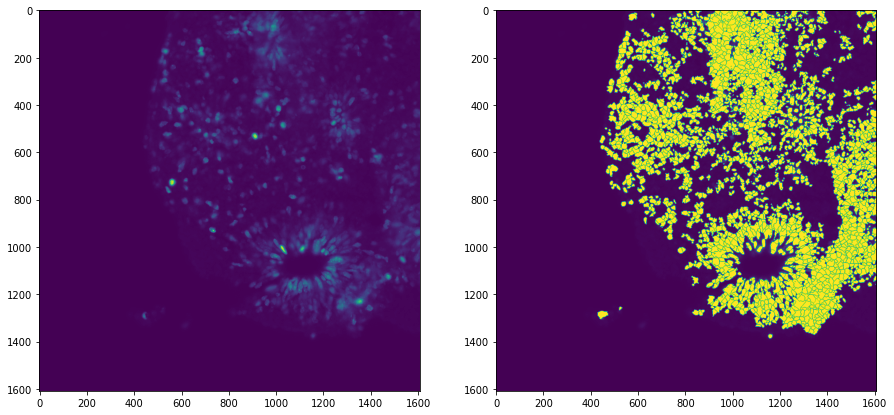

threshold is 600
D28_So10C3_03_KI67 positive count: 2423 out of 3700 cells, that's 65.48648648648648 %


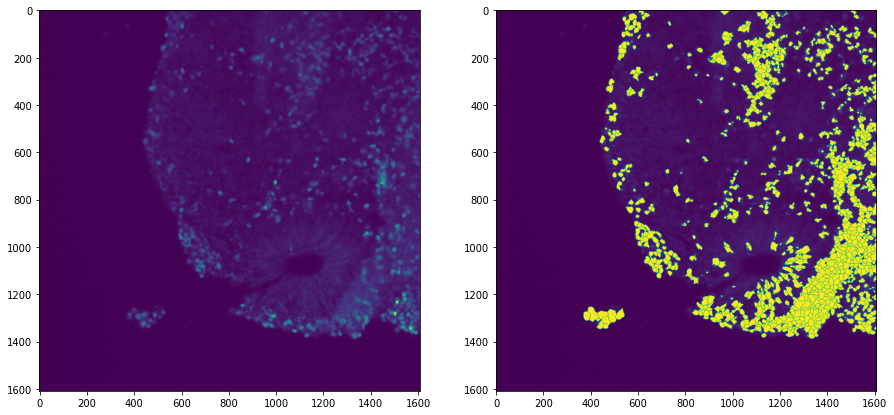

threshold is 600
D28_So10C3_03_TBR1 positive count: 1160 out of 3700 cells, that's 31.35135135135135 %
Colocalization of D28_So10C3_03_SOX2 D28_So10C3_03_KI67 is 845 out of 906 D28_So10C3_03_SOX2 positive cells, that's 93.26710816777042 %


In [62]:
print(thresholds)
thresholds = [600, 600, 600]
i = 0
image.df = save_df

for channel in image.channels:
  if channel.name == "dapi":continue
  t = thresholds[i]
  image.display_threshold(channel,t)
  print("threshold is",t)
  labels = channel.intensities>t
  image.df[channel.name+" positive"] = labels
  positive_count = np.sum(labels)
  print(channel.name,"positive count:",positive_count,"out of",image.cell_count,"cells, that's",100*positive_count/image.cell_count,"%")
  i+=1

image.df.to_csv(csv_output_path)

coloc = np.logical_and(image.df[image.channels[1].name+" positive"],image.df[image.channels[2].name+" positive"])

print("Colocalization of",image.channels[1].name,image.channels[2].name,"is",np.sum(coloc),
      "out of",np.sum(image.df[image.channels[1].name+" positive"]),image.channels[1].name,
      "positive cells, that's",100*np.sum(coloc)/np.sum(image.df[image.channels[1].name+" positive"]),"%")